# BB84 protocol implementation using Pennylane
##### by Giulia LM
----
Quantum Key Distribution (QKD) is one of the most advanced applications of quantum cryptography, allowing secure keys to be generated between two parties over a quantum channel. The first and most famous protocol proposed by Bennett and Brassard in 1984
 


## Protocol outline

Suppose Alice, the sender, wants to generate and share an encryption key with Bob, but cannot do so over the classical channel because Eve, an eavesdropper, has access to it.

<img src="images/channels.png" alt="drawing" width="500"/> 

Alice then generates a random set of bits, and for each one, chooses a diagonal or rectangular basis (x, +) with which to prepare the photon. She sends the photons to Bob over the quantum channel. Bob receives them and measures them using a random basis, collapsing each qubit into a state. If Bob chose the same basis as Alice, he will obtain the bit Alice chose. However, if Bob chooses a different basis, the probability of obtaining the prepared bit is 50%. 

<img src="images/basis.png" alt="drawing" width="500" /> 

Over the classical channel, Alice and Bob compare the bases they used and only retain the bits where they match, obtaining the final key. If Eve intercepts a qubit, she alters the states by measuring with incorrect bases, revealing her presence.

## Implementation with pennylane


In [1]:
import pennylane as qml
import random

The "default.mixed" device allows us to introduce noise to the channel:

In [2]:
dev = qml.device("default.mixed", wires=1, shots=1)

In [3]:
@qml.qnode(dev)
def bb84_circuit(alice_bit, aliceBasis, eveBasis, p):
    #alice prepares her bits
    if alice_bit == 1:
        qml.PauliX(wires=0)
    if aliceBasis == 'x':
        qml.Hadamard(wires=0)

    # introducing noise into the channel with probability p
    qml.DepolarizingChannel(p ,wires =0)
    qml.BitFlip(p ,wires =0)

    # eve meassures without reseting
    if eveBasis == 'x':
        qml.Hadamard(wires=0)

    eve_bit = qml.sample(wires=0)

    return eve_bit


In [4]:

@qml.qnode(dev)
def bob_circuit(eve_bit, eveBasis, bobBasis, p):
   # eve reprepares according to what she measured
    if eve_bit == 1:
        qml.PauliX(wires=0)
    if eveBasis == 'x':
        qml.Hadamard(wires=0)

    qml.DepolarizingChannel(p ,wires =0)
    qml.BitFlip(p ,wires =0)

    # bob measures
    if bobBasis == 'x':
        qml.Hadamard(wires=0)
    return qml.sample(wires=0)

In [5]:
def bb84(n, p, p_range=[0.6,0.4], sample=True):
    alice_bits = [random.choices([0, 1], weights=p_range)[0] for _ in range(n)]
    aliceBasis = [random.choices(['+', 'x'], weights=p_range)[0] for _ in range(n)]
    bobBasis = [random.choices(['+', 'x'], weights=p_range)[0] for _ in range(n)]
    eveBasis = [random.choices(['+', 'x'], weights=p_range)[0] for _ in range(n)]

    bob_bits = []
    eve_bits = []

    for i in range(n):
        eve_bit = int(bb84_circuit(alice_bits[i], aliceBasis[i], eveBasis[i], p))
        bob_bit = int(bob_circuit(eve_bit, eveBasis[i], bobBasis[i], p))
        eve_bits.append(eve_bit)
        bob_bits.append(bob_bit)

    bob_sifted = []
    alice_sifted = []

    for i in range(n):
        if aliceBasis[i] == bobBasis[i]:
            bob_sifted.append(bob_bits[i])
            alice_sifted.append(alice_bits[i])

    if sample:
        return alice_sifted, bob_sifted, eve_bits
    else:
        return aliceBasis, alice_bits, bobBasis, bob_bits, eveBasis, eve_bits, alice_sifted

In [6]:
import pandas as pd

In [7]:
n = 16
noise_p = 0.01
p_range = [0.6,0.4]

aliceBasis, alice_bits, bobBasis, bob_bits, eveBasis, eve_bits, alice_sifted = bb84(n, noise_p, p_range, False)

data = [aliceBasis, alice_bits, bobBasis, bob_bits, eveBasis, eve_bits]

rows = [
    "Alice basis",
    "Alice sended bits",
    "Bob measuring basis",
    "Bob measured bits",
    "Eve Basis",
    "Eve measured bits"
]

df = pd.DataFrame(data, index=rows)
df.columns = [''] * df.shape[1]

print(df)
print("Final key:",alice_sifted)

                                                                   
Alice basis          +  +  x  +  +  +  x  x  +  x  +  +  +  x  x  +
Alice sended bits    0  1  0  0  0  0  1  1  1  1  1  0  0  0  0  0
Bob measuring basis  x  x  +  +  +  +  +  x  x  x  x  +  x  +  x  +
Bob measured bits    0  1  0  0  0  0  1  0  0  0  1  0  0  0  1  0
Eve Basis            x  +  +  +  +  x  +  +  +  +  x  +  +  x  +  +
Eve measured bits    0  1  0  0  0  0  1  1  1  1  1  0  0  0  1  0
Final key: [0, 0, 0, 1, 1, 0, 0, 0]


### Privacy Amplification 
is used by alce and bob to distill from the key a smaller set of bits S whose correlation with the bits eve obtained is below a desired threshold

In [8]:
import secrets
import math

In [9]:
def gen_random_hasher(max_val=1024):
    seed = secrets.randbits(64)
    return lambda val: (hash(val) ^ seed) % max_val

In [10]:
def privacy_amplification(g, bob_sifted, final_len): 
    sifted_key = "".join(str(b) for b in bob_sifted)
    x = int(sifted_key, 2)
    return bin(g(x))[2:].zfill(final_len)

In [11]:
final_len = 32
g = gen_random_hasher(2**final_len)

bob_final_key = privacy_amplification(g, bob_sifted, final_len)
alice_final_key = privacy_amplification(g, alice_sifted, final_len)

print("A final key: ", alice_final_key)
print("B final key: ", bob_final_key)

NameError: name 'bob_sifted' is not defined

## channel security check

In [ ]:
def is_secure(threshold, alice_final_key, bob_final_key):
    error = sum(e != k for e,k in zip(alice_final_key, bob_final_key))/len(alice_final_key)
    if error < threshold:
        return True
    else:
        return False

In [ ]:
is_secure(0.4, alice_final_key, bob_final_key)

True

lets compute eve's error

In [ ]:
def compute_error(eve_bits, final_key):
    eve_bits = "".join(str(b) for b in eve_bits)
    correct_eve_guesses = sum(e == k for e,k in zip(eve_bits, final_key))
    error = correct_eve_guesses / len(final_key)

    return error

In [ ]:
eves_error = compute_error(eve_bits, bob_final_key)
print(f"Eve’s guessing probability: {eves_error}")

Eve’s guessing probability: 0.53125


# entropy calculation: H(A), H(B), H(E) 

In [ ]:
from collections import Counter
from scipy.stats import entropy
from math import log
import numpy as np
from itertools import product

In [ ]:
def shannon_entropy(bits):
    entropy = 0
    reps = Counter(bits)
    for elemento in reps:
        p = reps[elemento] / len(bits)
        entropy -= p * math.log2(p)
    
    return entropy

## Conditional Entropy

- H(A|B) measures how uncertain we are about a variable A given that we already know B

![](mrkdwn/condH.png "a title")

In [ ]:

def conditional_entropy(X,Y):
    conjuntion = zip(X,Y)
    conjuntion_counter = Counter(conjuntion)
    freq_total_conjuntion = np.sum(list(conjuntion_counter.values()))

    Y_count = Counter(Y)
    freq_total_Y = np.sum(list(Y_count.values()))

    h = 0
    for x,y in product(np.unique(X),np.unique(Y)):
        if conjuntion_counter[(x,y)] != 0:
            h += (conjuntion_counter[(x,y)]/freq_total_conjuntion)*np.log2((Y_count[y]/freq_total_Y)/(conjuntion_counter[(x,y)]/freq_total_conjuntion))

    return h


## información mutua

quantifies how much information two variables share.
how much does knowing B reduce uncertainty about A, and vice versa

In [ ]:
def mutual_inf(X, Y):
    return shannon_entropy(X) - conditional_entropy(X, Y) 

In [ ]:
h_A = shannon_entropy(alice_sifted)
h_B = shannon_entropy(bob_sifted)
h_E = shannon_entropy(eve_bits)

hA_E = conditional_entropy(alice_sifted, eve_bits)
hB_E = conditional_entropy(bob_sifted, eve_bits)

I_AE = mutual_inf(alice_sifted, eve_bits)
I_BE = mutual_inf(bob_sifted, eve_bits)

In [ ]:
entropy = [h_E, hA_E, hB_E,I_AE, I_BE]
nombres_filas = [
    "H(E)",
    "H(A|E)",
    "H(B|E)",
    "I(A;E)",
    "I(B;E)"
]
df = pd.DataFrame(entropy, index=nombres_filas)
df.columns = [''] * df.shape[1]
df

,
H(E),0.954434
H(A|E),0.927450
H(B|E),0.895688
I(A;E),0.055926
I(B;E),0.071606


# pruebas y gráficos

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
eves_guessing_p = []
condH_BobEve = []
condH_AlEve = []
MI_AlEve = []
MI_BobEve = []


m = 500
n = 64
noise_p = 0.3
final_len = 32
p_range=[0.6,0.4]

channel_sec = 0.4

for i in range(m):
    alice_sifted, bob_sifted, eve_bits = bb84(n, noise_p, p_range)
    """ 
    g = gen_random_hasher(2**final_len)
    bob_final_key = privacy_amplification(g, bob_sifted, final_len)
    alice_final_key = privacy_amplification(g, alice_sifted, final_len)
    """
    #if not is_secure(channel_sec, alice_final_key, bob_final_key):
    if not is_secure(channel_sec, alice_sifted, bob_sifted):
        pass
    
    eves_guessing_p.append(compute_error(eve_bits, bob_sifted))

    condH_AlEve.append(conditional_entropy(alice_sifted, eve_bits))
    condH_BobEve.append(conditional_entropy(bob_sifted, eve_bits))

    MI_AlEve.append(mutual_inf(alice_sifted, eve_bits))
    MI_BobEve.append(mutual_inf(bob_sifted, eve_bits))

In [ ]:
print("Media de las coincidencias de Eve: ", np.mean(eves_guessing_p))

Media de las coincidencias de Eve:  0.0


In [ ]:
"""plt.hist(eves_guessing_p, color='mediumseagreen')
plt.title("Probabilidad de que Eve adivine")
plt.xlabel("p")
plt.ylabel("frec")
 
plt.show()"""

'plt.hist(eves_guessing_p, color=\'mediumseagreen\')\nplt.title("Probabilidad de que Eve adivine")\nplt.xlabel("p")\nplt.ylabel("frec")\n\nplt.show()'

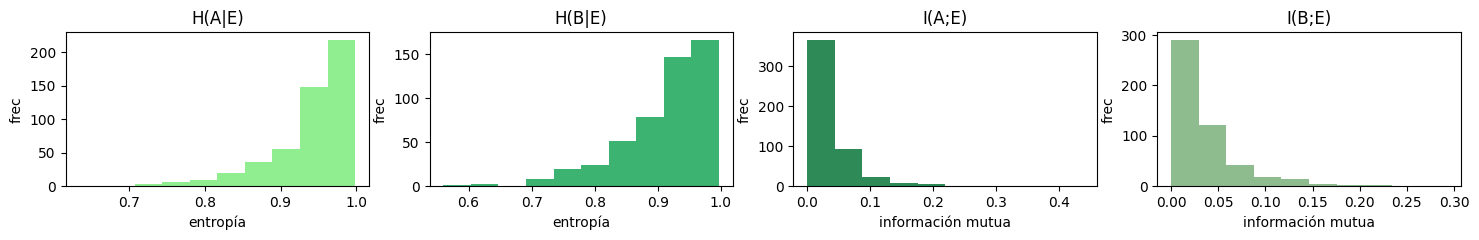

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(18, 2))

axs[0].hist(condH_BobEve, color='lightgreen')
axs[0].set_title("H(A|E)")
#axs[0].text()
axs[0].set_xlabel('entropía')

axs[1].hist(condH_AlEve, color='mediumseagreen')
axs[1].set_title("H(B|E)")
axs[1].set_xlabel('entropía')
axs[2].hist(MI_AlEve, color='seagreen')
axs[2].set_title("I(A;E)")
axs[2].set_xlabel('información mutua')
axs[3].hist(MI_BobEve, color='darkseagreen')
axs[3].set_title("I(B;E)")
axs[3].set_xlabel('información mutua')

for ax in axs.flat:
    ax.set(ylabel='frec')

In [ ]:
agregar chequeo de seguridad con subset S de intercambio y cortar comunicación
revisar los efectos del ruido en la clave final
probar distitos tipos/maneras d aplicar ruido al canal 

SyntaxError: invalid syntax (2902908757.py, line 1)